In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Dataset

In [2]:
! wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv -O data-week-4.csv 

--2023-10-09 22:16:10--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1,4M) [text/plain]
Saving to: ‘data-week-4.csv’

data-week-4.csv     100%[===================>]   1,41M  1,47MB/s    in 1,0s    

2023-10-09 22:16:11 (1,47 MB/s) - ‘data-week-4.csv’ saved [1475504/1475504]



In [3]:
df = pd.read_csv('data-week-4.csv')

columns_to_process = ['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders', 'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP']
df = df[columns_to_process]
df.columns = df.columns.str.lower().str.replace(' ', '_').str.lower()

df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


In [4]:
df.isnull().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64

In [5]:
df.engine_hp = df.engine_hp.fillna(0)
df.engine_cylinders = df.engine_cylinders.fillna(0)

In [6]:
df.isnull().sum()

make                 0
model                0
year                 0
engine_hp            0
engine_cylinders     0
transmission_type    0
vehicle_style        0
highway_mpg          0
city_mpg             0
msrp                 0
dtype: int64

In [7]:
df.rename(columns={'msrp': 'price'}, inplace=True)
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


In [8]:
df['above_average'] = (df.price > df.price.mean()).astype(int)
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500,0


In [9]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

len(df), len(df_train), len(df_val), len(df_test)

(11914, 7148, 2383, 2383)

In [10]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train_above_average = df_train.above_average.values
y_val_above_average = df_val.above_average.values
y_test_above_average = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

del df_train['price']
del df_val['price']
del df_test['price']

# Q1

In [11]:
from sklearn.metrics import auc

In [12]:
def tpr_fpr_scoring(x, y):

    x_min = x.min()
    x_max = x.max()
    
    scores = []

    thresholds = np.linspace(x_min, x_max, 100)

    for t in thresholds:
        actual_positive = (y == 1)
        actual_negative = (y == 0)

        predict_positive = (x >= t)
        predict_negative = (x < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [13]:
def plot_metrics(df_scores, label_x, label_y):
    plt.figure(figsize=(5, 5))
    
    plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
    
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    
    plt.legend()
                 

engine_hp 0.9162400137593407
engine_cylinders 0.766116490165669
highway_mpg 0.3724164644901085
city_mpg 0.32907330939247487


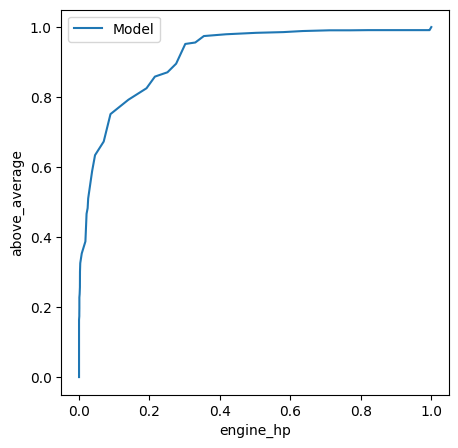

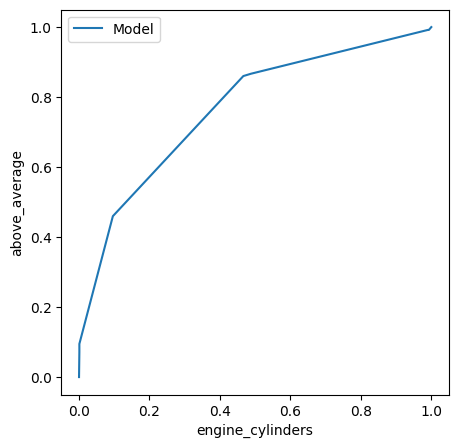

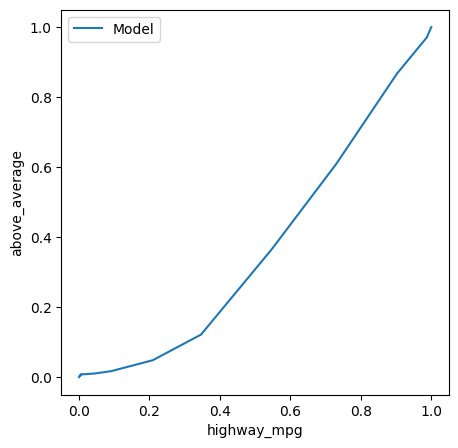

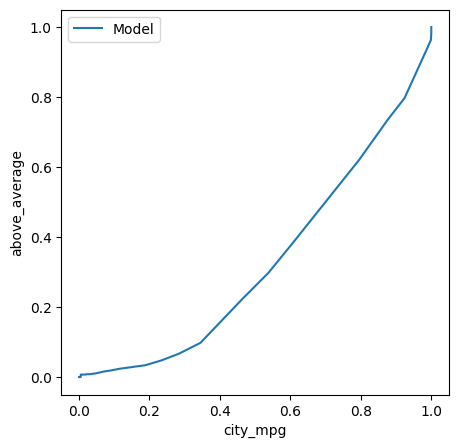

In [14]:
for m in ["engine_hp", "engine_cylinders", "highway_mpg", "city_mpg"]:
    df_scores = tpr_fpr_scoring(df_train[m], y_train_above_average)
    plot_metrics(df_scores, m, "above_average")
    print(m, auc(df_scores.fpr, df_scores.tpr))


In [15]:
df_scores = tpr_fpr_scoring(df_train.engine_hp, y_train_above_average)
auc_score = auc(df_scores.fpr, df_scores.tpr)
print("engine_hp", auc_score)

engine_hp 0.9162400137593407


In [16]:
df_scores = tpr_fpr_scoring(df_train.engine_cylinders, y_train_above_average)
auc_score = auc(df_scores.fpr, df_scores.tpr)
print("engine_cylinders", auc_score)

engine_cylinders 0.766116490165669


In [17]:
df_scores = tpr_fpr_scoring(-df_train.highway_mpg, y_train_above_average)
auc_score = auc(df_scores.fpr, df_scores.tpr)
print("highway_mpg", auc_score)

highway_mpg 0.6275868373573984


In [18]:
df_scores = tpr_fpr_scoring(-df_train.city_mpg, y_train_above_average)
auc_score = auc(df_scores.fpr, df_scores.tpr)
print("city_mpg", auc_score)

city_mpg 0.6709266906075251


# Q2

In [19]:
categorical = ['make', 'model', 'transmission_type', 'vehicle_style']
numerical = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

all_columns = categorical + numerical

In [20]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [21]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[all_columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [22]:
dv, model = train(df_train, y_train_above_average)

In [23]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [24]:
y_pred = predict(df_val, dv, model)

In [26]:
def tpr_fpr_dataframe(y_val, y_pred, steps=1001):
    scores = []

    thresholds = np.linspace(0, 1, steps)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [27]:
df_scores = tpr_fpr_dataframe(y_val_above_average, y_pred, 0.001)

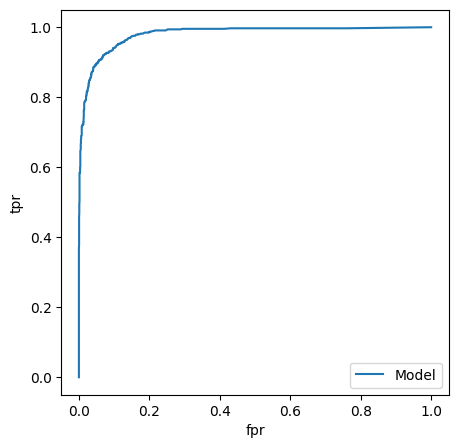

In [28]:
plot_metrics(df_scores, "fpr", "tpr")

In [29]:
auc(df_scores.fpr, df_scores.tpr)

0.979788037489631

# Q3

In [31]:
df_scores = tpr_fpr_dataframe(y_val_above_average, y_pred, 101)

In [32]:
p = df_scores.tp / (df_scores.tp + df_scores.fp)
r = df_scores.tp / (df_scores.tp + df_scores.fn)

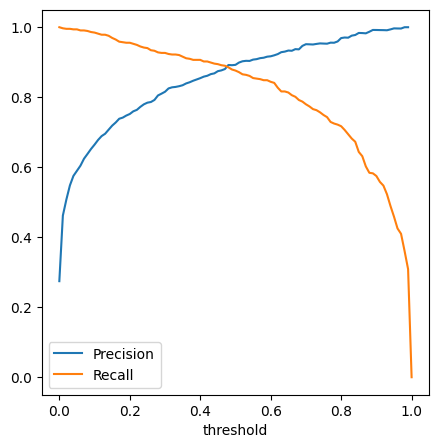

In [33]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.threshold, p, label='Precision')
plt.plot(df_scores.threshold, r, label='Recall')

plt.xlabel("threshold")
#plt.ylabel("Precision/Recall")

plt.legend()

# Q4

In [34]:
f1score = 2 * p * r / (p + r)

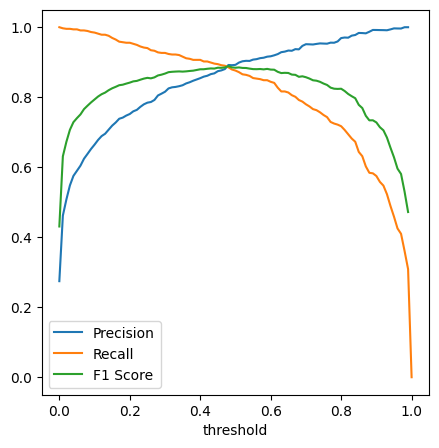

In [35]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.threshold, p, label='Precision')
plt.plot(df_scores.threshold, r, label='Recall')
plt.plot(df_scores.threshold, f1score, label='F1 Score')

plt.xlabel("threshold")
#plt.ylabel("Precision/Recall")

plt.legend()

# Q5

In [36]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score

In [37]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(np.mean(scores), round(np.std(scores), 3))

0.9796153529141989 0.003


# Q6

In [39]:
n_splits = 5

for C in tqdm([0.01, 0.1, 0.5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.952 +- 0.003
C=0.1 0.972 +- 0.002
C=0.5 0.978 +- 0.002
C=10 0.982 +- 0.003
